In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

import os
from functools import lru_cache
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline
torch.__version__, torchvision.__version__

('1.5.0+cu101', '0.6.0+cu101')

## Dataset

In [2]:
data_home = Path(os.environ['HOME'])
data_home = data_home/'.fastai/data/biwi_head_pose'

formula from https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson3-head-pose.ipynb

In [3]:
class HeadPoseDataset(object):
    def __init__(self, home: Path, transform=None):
        self.home = home
        self.images = list(home.glob('**/*.jpg'))
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    @lru_cache(maxsize=None)
    def cal(self, parent):
        cal = np.genfromtxt(parent/'rgb.cal', skip_footer=6)
        return cal
    
    def get_landmark(self, image: Path):
        p = image.parent
        pose = p/image.name.replace('rgb', 'pose').replace('jpg', 'txt')
        pose = np.genfromtxt(pose, skip_header=3)
        cal = self.cal(p)
        c1 = pose[0] / pose[2] * cal[0, 0] + cal[0, 2]
        c2 = pose[1] / pose[2] * cal[1, 1] + cal[1, 2]
        return np.array([c1, c2], dtype=np.int64)
    
    @staticmethod
    def image_landmark(image, landmark):
        from PIL import ImageDraw
                
        base = image.convert('RGBA')
        alpha = Image.new('RGBA', base.size, (255, 255, 255, 0))  # white, transparent
        draw = ImageDraw.Draw(alpha)
        landmark = np.concatenate([landmark - 5, landmark + 5])
        draw.ellipse(list(landmark), fill=(255, 0, 0, 255))  # red, opaque
        
        return Image.alpha_composite(base, alpha)
    
    def __getitem__(self, index):
        image = Image.open(self.images[index])
        landmark = self.get_landmark(self.images[index])
        
        if self.transform:
            image, landmark = self.transform(image, landmark)
            
        return image, landmark

In [4]:
dataset = HeadPoseDataset(data_home)

In [5]:
len(dataset)

15678

In [6]:
heights, widths = [], []
for image, _ in dataset:
    heights.append(image.height)
    widths.append(image.width)

In [7]:
min(heights), max(heights), min(widths), max(widths)

(480, 480, 640, 640)

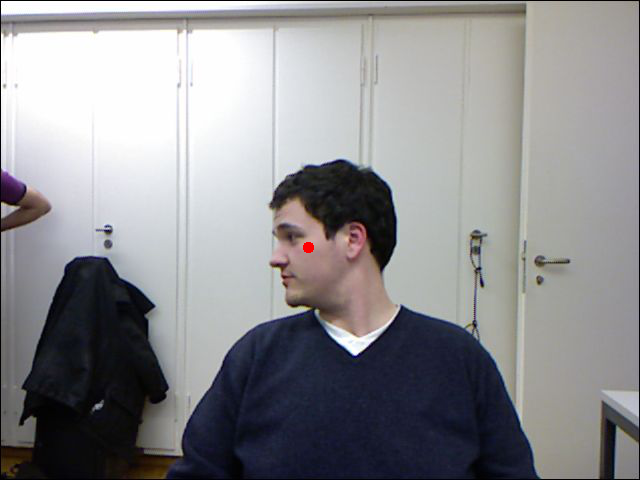

In [8]:
image, landmark = dataset[20]
HeadPoseDataset.image_landmark(image, landmark)

## Transforms

In [9]:
class Compose(object):
    
    def __init__(self, transforms):
        self.transforms = transforms
        
    def __call__(self, image, landmark):
        for transform in self.transforms:
            image, landmark = transform(image, landmark)
            
        return image, landmark
    
class Resize(object):
    
    def __init__(self, height):
        self.image_height = 480  # hard code
        self.height = height
        self.resize = transforms.Resize(self.height)
        
    def __call__(self, image, landmark):
        image = self.resize(image)
        landmark = landmark * self.height / self.image_height
        
        return image, landmark


class ToTensor(object):
    
    def __call__(self, image, landmark):
        image = transforms.ToTensor()(image)
        landmark = torch.from_numpy(landmark).float()
        return image, landmark


class Normalize(object):
    
    def __init__(self):
        self.image_width = 640  # hard code
        self.scale = 256 / 480
    
    def __call__(self, image, landmark):
        normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])
        image = normalize(image)
        landmark = landmark / (self.image_width * self.scale)
        
        return image, landmark

In [10]:
dataset = HeadPoseDataset(data_home, transform=Compose([
    Resize(256),
    ToTensor(),
    Normalize(),
]))

In [11]:
image, landmark = dataset[0]

In [12]:
image.shape

torch.Size([3, 256, 341])

In [13]:
landmark.dtype

torch.float32

## Dataloader

In [14]:
val_fraction = 0.8

def get_data_loaders(dataset, val_fraction, train_batch_size, val_batch_size):
    train_size = int(val_fraction * len(dataset))
    val_size = len(dataset) - train_size
    trainset, valset = torch.utils.data.random_split(
        dataset, [train_size, val_size])
    train_loader = torch.utils.data.DataLoader(
        trainset,
        batch_size=train_batch_size,
        shuffle=True,
        num_workers=6,
    )
    val_loader = torch.utils.data.DataLoader(
        valset,
        batch_size=train_batch_size,
        shuffle=False,
    )
    return {'train': train_loader, 'val': val_loader}

### check data loaders

In [15]:
data_loaders = get_data_loaders(dataset, 0.8, 128, 1000)
images, landmarks = next(iter(data_loaders['train']))

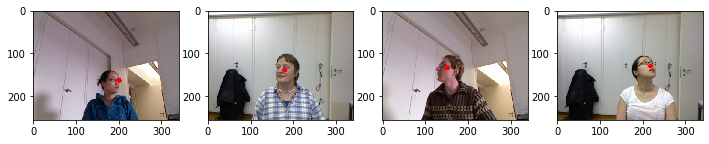

In [16]:
fix, axs = plt.subplots(1, 4, figsize=(12, 4))

for j, (image, landmark) in enumerate(zip(images, landmarks)):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    image = std * image + mean
    image = transforms.ToPILImage()(image)
    landmark = landmark.numpy() * 640 * 256 / 480
    landmark = landmark.astype(np.int64)
    image = HeadPoseDataset.image_landmark(image, landmark)
    axs[j].imshow(image)
    if j == 3:
        break

## Model

In [17]:
model = models.resnet18(pretrained=True)

for param in model.fc.parameters():
    param.requires_grad = False

In [18]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

### replace the last layer

In [19]:
model.fc = nn.Linear(512, 2)

## Train

### lr_finder

In [27]:
import ignite
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import RootMeanSquaredError, Loss
from ignite.contrib.handlers import FastaiLRFinder
from ignite.contrib.handlers.tqdm_logger import ProgressBar

device = 'cuda' if torch.cuda.is_available() else 'cpu'
ignite.__version__

'0.4.0.dev20200523'

In [21]:
data_loaders = get_data_loaders(dataset, 0.8, 128, 1000)

model = models.resnet18(pretrained=True)

for param in model.fc.parameters():
    param.requires_grad = False
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 2)
model.to(device)

criterion = nn.MSELoss()

optimizer = optim.SGD(model.parameters(), lr=5e-4, momentum=0.9)

In [22]:
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
ProgressBar(persist=False).attach(trainer, output_transform=lambda x: {'batch loss': x})
lr_finder = FastaiLRFinder()
to_save = {'model': model, 'optimizer': optimizer}
with lr_finder.attach(trainer, to_save, diverge_th=1.5) as trainer_with_lr_finder:
    trainer_with_lr_finder.run(data_loaders['train'])

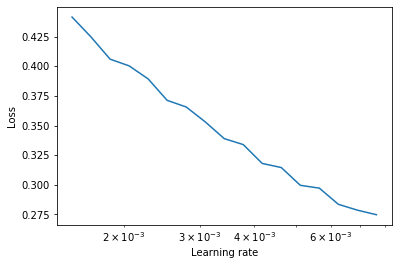

0.0007490697326301009

In [23]:
lr_finder.get_results()
lr_finder.plot()
lr_finder.lr_suggestion()

### Train

* Todos
    * model을 load할 수 있게 변경 필요
    * lr scheduler 이용하도록 변경 펼요

In [28]:
def run(dataset, val_fraction,
        train_batch_size, val_batch_size, epochs, lr, momentum, device):
    data_loaders = get_data_loaders(
        dataset, val_fraction,
        train_batch_size, val_batch_size)

    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 2)
    model.to(device)

    criterion = nn.MSELoss()

    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    
    trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
    evaluator = create_supervised_evaluator(
        model,
        metrics={'acc': RootMeanSquaredError(), 'loss': Loss(criterion)},
        device=device
    )
    
    pbar = ProgressBar(persist=True)
    pbar.attach(trainer, metric_names='all')
    
    @trainer.on(Events.EPOCH_COMPLETED)
    def log_results(engine):
        logs = dict()
        for dataset in ['train', 'val']:
            evaluator.run(data_loaders[dataset])
            metrics = evaluator.state.metrics
            pbar.log_message(f'Epoch {engine.state.epoch}, [{dataset}],'
                             f'\tacc={metrics["acc"]}  loss={metrics["loss"]}')
        pbar.n = pbar.last_print_n = 0
        
    trainer.run(data_loaders['train'], max_epochs=epochs)
    
    return model

In [29]:
model = run(dataset, 0.8, 128, 1000, 10, 7e-4, 0.9, device)


Epoch 1, [train],	acc=0.15196751644086043  loss=0.011547063038037061
Epoch 1, [val],	acc=0.15289577627952441  loss=0.011688559202059192



Epoch 2, [train],	acc=0.13240601362284996  loss=0.00876567622605403
Epoch 2, [val],	acc=0.1326529911983708  loss=0.00879840803693752



Epoch 3, [train],	acc=0.12122026609857481  loss=0.007347176465712425
Epoch 3, [val],	acc=0.12148681365698964  loss=0.007379522946264062



Epoch 4, [train],	acc=0.11290186937693093  loss=0.006373416058486884
Epoch 4, [val],	acc=0.11296268104013969  loss=0.006380283653888167



Epoch 5, [train],	acc=0.10738597632862838  loss=0.005765873959739183
Epoch 5, [val],	acc=0.10769020496254049  loss=0.00579859012243699



Epoch 6, [train],	acc=0.10215353779340258  loss=0.0052176726446758045
Epoch 6, [val],	acc=0.10251308979705596  loss=0.00525446678986963



Epoch 7, [train],	acc=0.09775568855158429  loss=0.004778087324844657
Epoch 7, [val],	acc=0.09799936556526956  loss=0.004801937825597671



Epoch 8, [train],	acc=0.09365447087886487  loss=0.0043855799609930956
Epoch 8, [val],	acc=0.09411703316530239  loss=0.004429007965919315



Epoch 9, [train],	acc=0.09148034721618965  loss=0.004184326964214128
Epoch 9, [val],	acc=0.09211158865567354  loss=0.004242272382336003



Epoch 10, [train],	acc=0.08722954343079097  loss=0.0038044966244631987
Epoch 10, [val],	acc=0.08784713891153245  loss=0.003858559907471039



Epoch 11, [train],	acc=0.08428713766206351  loss=0.0035521607898595115
Epoch 11, [val],	acc=0.08502986262234544  loss=0.003615038768787469



Epoch 12, [train],	acc=0.08232637101159888  loss=0.003388815684197404
Epoch 12, [val],	acc=0.0830399998658187  loss=0.003447820788857584



Epoch 13, [train],	acc=0.07973910897686536  loss=0.0031791627513260493
Epoch 13, [val],	acc=0.08059817462195218  loss=0.003248032876195348



Epoch 14, [train],	acc=0.0783131916734304  loss=0.003066477995893672
Epoch 14, [val],	acc=0.07909130160597161  loss=0.0031277169948633835



Epoch 15, [train],	acc=0.07607254943804251  loss=0.002893516390115555
Epoch 15, [val],	acc=0.0768778501238897  loss=0.0029551019198356234



Epoch 16, [train],	acc=0.07481847764904187  loss=0.0027989022996769085
Epoch 16, [val],	acc=0.07573907763420673  loss=0.0028682039404401972



Epoch 17, [train],	acc=0.07378559455806498  loss=0.002722156982329215
Epoch 17, [val],	acc=0.07468479220336288  loss=0.0027889090932297464



Epoch 18, [train],	acc=0.07099576612060154  loss=0.0025201994052334725
Epoch 18, [val],	acc=0.07195104877758937  loss=0.002588476710097522



Epoch 19, [train],	acc=0.07014285053025389  loss=0.002460009742185433
Epoch 19, [val],	acc=0.071157386426095  loss=0.002531686821496304



Epoch 20, [train],	acc=0.06891826568239234  loss=0.002374863673448254
Epoch 20, [val],	acc=0.06995555461571719  loss=0.002446889810796295


In [30]:
torch.save(model.state_dict(), 'model-checkpoint-1.pth')

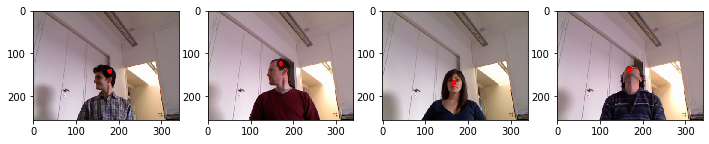

In [35]:
model.to('cpu')
model.eval()

images, landmarks = next(iter(data_loaders['val']))
landmarks_predicted = model(images)

fix, axs = plt.subplots(1, 4, figsize=(12, 4))

for j, (image, landmark) in enumerate(zip(images, landmarks_predicted)):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    image = std * image + mean
    image = transforms.ToPILImage()(image)
    landmark = landmark.detach().numpy() * 640 * 256 / 480
    landmark = landmark.astype(np.int64)
    image = HeadPoseDataset.image_landmark(image, landmark)
    axs[j].imshow(image)
    if j == 3:
        break

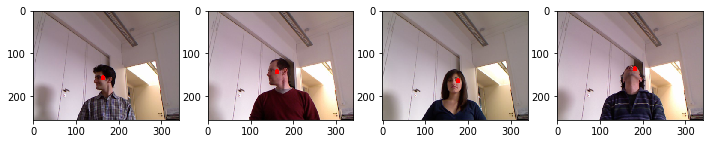

In [36]:
fix, axs = plt.subplots(1, 4, figsize=(12, 4))

for j, (image, landmark) in enumerate(zip(images, landmarks)):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    image = std * image + mean
    image = transforms.ToPILImage()(image)
    landmark = landmark.numpy() * 640 * 256 / 480
    landmark = landmark.astype(np.int64)
    image = HeadPoseDataset.image_landmark(image, landmark)
    axs[j].imshow(image)
    if j == 3:
        break